# MNIST Classification via a Neural Network

In the the [MNIST SVM example](../svm/mnist_svm.ipynb), we introduced the classic MNIST digit classification problem and trained a simple SVM classifier for the model.  In this demo, we will try a simple neural network.  The network we will create will not perform quite as well -- we will obtain an accuracy of only around 97%, while the SVM classifier obtains an accuracy of over 98%.  However, once we understand these simple neural networks, we will be able to build more sophisticated networks that can obtain much better classification rate.  Also, in doing this demo, you will learn several important features of the `keras` package in addition to the concepts shown in the [simple neural network example](./synthetic.ipynb):

* How to construct multi-class classifiers using categorical cross entropy.
* How to optimize using mini-batches.
* How to save and load the model after training.  

## Loading the Keras package and the MNIST data

We first load the `Tensorflow` package as in the [simple neural network example](./synthetic.ipynb).

In [22]:
import tensorflow as tf

We also load some other common packages.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

Next, we get the MNIST data as in the [MNIST SVM example](../svm/mnist_svm.ipynb).  We reshape and rescale the input `X` from values from -1 to 1 as this works better for the neural network.

In [24]:
(Xtr,ytr),(Xts,yts) = tf.keras.datasets.mnist.load_data()

Xtr = 2*(Xtr/255 - 0.5)
ntr, nrow, ncol = Xtr.shape
Xtr = Xtr.reshape((ntr,nrow*ncol))

Xts = 2*(Xts/255 - 0.5)
nts, nrow, ncol = Xts.shape
Xts = Xts.reshape((nts,nrow*ncol))

We will also use the `plt_digit` function from the [MNIST SVM example](../svm/mnist_svm.ipynb) to display digits.

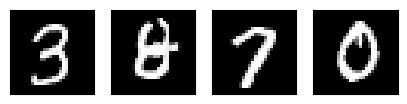

In [25]:
def plt_digit(ax, x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    ax.imshow(xsq,  cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])
    
# Select random digits
nplt = 4
nsamp = Xtr.shape[0]
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
fig, ax = plt.subplots(1,nplt, figsize=(5,10))
for i in range(nplt):
    ind = Iperm[i]    
    plt_digit(ax[i], Xtr[ind,:])

## Creating a Simple Neural Network.

To create the neural network, we first import the appropriate sub-packages.

In [26]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Activation

Next, we clear the session.  As in the [simple neural network example](./synthetic.ipynb), this step is not necessary, but it is good practice as it clears any model layers that you have built before.  

In [27]:
import tensorflow.python.keras.backend as K
K.clear_session()

Now we create a very simple network.  The features are:
*  We have one hidden layer with `nh=100` units.  
*  One output layer with `nout=10` units, one for each of the 10 possible classes
*  The output activation is `softmax`, which is used for multi-class targets

In [28]:
nin = Xtr.shape[1]  # dimension of input data
nh = 100     # number of hidden units
nout = int(np.max(ytr)+1)    # number of outputs = 10 since there are 10 classes
model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='softmax', name='output'))

We print the model summary. 

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 100)               78500     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


## Training the Network

As before, to train the network, we have to select an optimizer and a loss function.  Since this is a multi-class classification problem, we select the `sparse_categorial_crossentropy` loss.  We use the `adam` optimizer as before.  You may want to play with the learning rate `lr`.   We also set the `metrics` that we wish to track during the optimization.  In this case, we select `accuracy` on the training set.

In [30]:
# from tensorflow.python.keras import optimizers
from tensorflow.python.keras.optimizer_v2 import adam

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Keras provides a simple method `fit` to run the optimization.  You simply specify the number of epochs and the batch size, both discussed in class.  In addition, we specify the `validation_data` so that it can print the accuracy on the test data set as it performs the optimization.

In [31]:
hist = model.fit(Xtr, ytr, epochs=30, batch_size=100, validation_data=(Xts,yts))

AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'

After running the 10 epochs, you should obtain a test accuracy of around 96.5%.  If we run it for another a few epochs, we can get slightly higher results.  We can just run the `model.fit` command again, and it will start where it left off. You should get a little more than 97% accuracy. 

Plot the training accuracy and validation accuracy as a function of epoches.
We see that the training accuracy keeps growing to 1, while the validation accuracy saturates to a value around 0.97

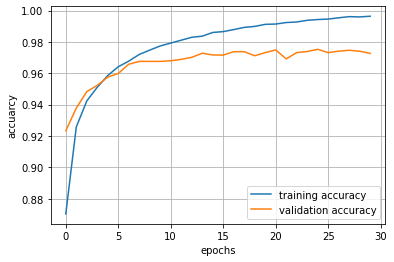

In [11]:
tr_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

In [12]:
score, acc = model.evaluate(Xts, yts, verbose=1)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Saving and Loading the model

Since the training takes a long time, it is useful to save the results.  See the [keras page](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) for many more useful saving and loading features.

In [13]:
model.save("mnist_mod.h5")

We can now reload the model with the `load_model` command.

In [14]:
from tensorflow.keras.models import load_model

model1 = load_model("mnist_mod.h5")
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 100)               78500     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


We can test the performance on the test data set.  We can do this in two steps:

* We first compute the output logits, `z`, on the test data, `Xts`.  This will produce a matrix with 10 columns with one logits for each class.  
* Then we compute the predicted class labels `yhat` by finding the index of the column with the maximum value.

In [15]:
z = model1.predict(Xts)
yhat = np.argmax(z,axis=1)

To see what happened, the code below prints the first 5 rows of the logits and the corresponding class estimate.

In [16]:
#mat = np.column_stack((z,yhat))
with np.printoptions(precision=3, suppress=True):
    for i in range(5):
        print('z[%d,:]='%i, z[i,:], ', yhat[%d]= '%i, yhat[i])

z[0,:]= [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] , yhat[0]=  7
z[1,:]= [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] , yhat[1]=  2
z[2,:]= [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] , yhat[2]=  1
z[3,:]= [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] , yhat[3]=  0
z[4,:]= [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] , yhat[4]=  4


In [17]:
acc = np.mean(yhat == yts)
print("accuracy = %f" % acc)

accuracy = 0.972700


You can also use the built-in metric function, `sparse_categorical_accuracy`.  The function returns one output for each sample, so you need to take the mean of the results.

In [18]:
from tensorflow.keras.metrics import sparse_categorical_accuracy
yts1 = yts.reshape(yts.shape[0],1)
acc = np.mean(sparse_categorical_accuracy(yts1,z))
print("accuracy = %f" % acc)

accuracy = 0.972700
